<img src ="../images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Co-kriging and co-SGS with Markov Model 1 (MM1)
#### Gator Glaciology Lab, University of Florida

We often have more extensively sampled secondary data that can provide some constraint on interpolations. For example, here we examine the case where there is ice surface elevation data that correlates with bed elevation. Unlike with bed measurements, the ice surface elevation is known at all locations. So if the ice surface and bed elevation are related, how do we use the ice surface to help improve our interpolations?

To answer this question, we can use co-kriging or co-SGS, which are the multivariate forms of kriging and SGS, respectively. While kriging computes interpolated values as the weighted sum of nearby meausurements, co-kriging uses the weighted sum of measurements from both variables. So co-kriging and co-SGS must account for the spatial relationships within and between both the primary and secondary data. This means that, in theory, one must compute the primary variogram (for the bed elevation data), the secondary variogram (for ice surface elevation), and the cross variogram. The cross variogram describes the spatial relationship between two variables:

$$
\gamma_{12}(h) = \frac{1}{2 N(h)} \sum^{N}_{\alpha=1} (Z_1(x_\alpha) - Z_1(x_\alpha + h))(Z_2(x_\alpha) - Z_2(x_\alpha + h))  
$$

where $x$ is a spatial location, $Z_1$ is the primary variable (bed elevation), $Z_2$ is the secondary variable (ice surface elevation) and $N$ is the number of lag distances. However, using all of these different variograms can lead to very large, unstable systems of equations that are difficult to solve. 

So in practice, people only use the nearest neighbor secondary point to the grid cell being estimated. Usually the nearest neighbor secondary data value is co-located with the grid cell of interest, meaning it is at the same location. So this approach is often referred to as collocated co-kriging or co-simulation. 

This simplification requires an assumption of conditional independence (a Markov assumption). There are two possible Markov models, referred to as Markov Models 1 and 2, respectively. Markov Model 1 is the most straightforward option to model, so we use this version in our package.

#### Markov Model 1 (MM1)

MM1 makes the following assumption of conditional independence:

$$
E(Z_2(u) | Z_1(u) = z_1, Z_1(u') = z_1(u')) = E(Z_2(u) | Z_1(u) = z_1)
$$

This reads as: The expected value of the secondary variable at location $u$, given knowledge of the primary data value at that same location $u$ as well as primary data at a further away location, $u'$, is the same as the expected value of $Z_2(u)$ when given primary data information only at location $u$. It means that the statistical relationship between the primary and secondary variable can be simplified. Under MM1 assumptions, the cross-correlogram model is written as:

$$
\rho_{12}(h) = \rho_{12}(0)\rho_1(h)
$$

where $h$ is the lag distance and $\rho$ is the correlogram, calculated by:

$$
\rho(h) = 1 - \gamma(h)
$$

assuming that $\gamma(h)$ is the variogram for data with a standard normal distribution. So the correlogram is just the variogram flipped upside down plus one. While the variogram measures spatial covariance, the correlogram measures spatial correlation. This means that $\rho_{12}(0)$, the correlogram at a lag distance of zero, is simply the correlation coefficient between variables 1 and 2.

In summary, to perform co-kriging and co-simulation under MM1 assumptions, all you need is the variogram of the primary (bed elevation) data, and the correlation coefficient between the primary and secondary data. We don't even have to model the variogram for the secondary data. 

Note that the primary and secondary data MUST undergo a normal score transformation prior to invoking MM1.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import gstatsim as gs
import random

# plotting utility functions
from plot_utils import splot2D, mplot1, make_colorbar

## Load and plot primary data

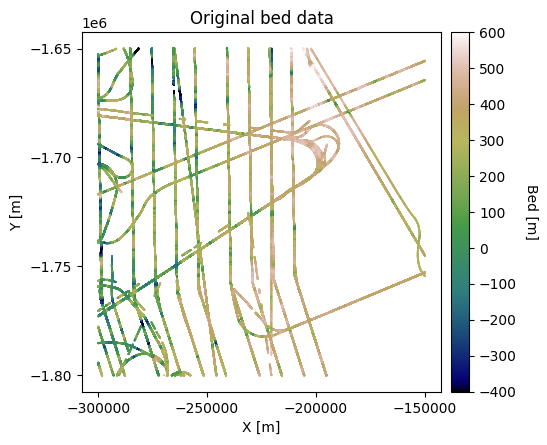

In [2]:
df_bed = pd.read_csv('data/greenland_test_data.csv') # download data
df_bed = df_bed[df_bed["Bed"] <= 700]  # remove erroneously high values, presumably due to bad bed picks

# plot original data
splot2D(df=df_bed, title='Original bed data')

## Load and plot secondary data

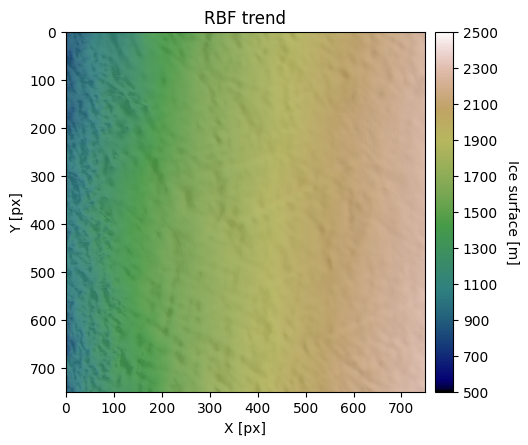

In [3]:
df_surface = pd.read_csv('Data/greenland_surface_data.csv') # download data

# make hillshade plot for visualizing
res = 200
xmin = np.min(df_surface['X']); xmax = np.max(df_surface['X'])     # min and max x values
ymin = np.min(df_surface['Y']); ymax = np.max(df_surface['Y']) 

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(df_surface['Surface'].values, (int(xlen), int(ylen)))
elevation = elevation.T 

# Shade from the northeast, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=45, altdeg=45)

# leaving the dx and dy as 1 means a vertical exageration equal to dx/dy
hillshade = ls.hillshade(elevation, vert_exag=1, dx=1, dy=1, fraction=1.0)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(elevation, vmin=500, vmax=2500, cmap='gist_earth')
ax.imshow(hillshade, cmap='Greys', alpha=0.1)
ax.set_title('RBF trend')
ax.set_xlabel('X [px]'); ax.set_ylabel('Y [px]')
cbar = make_colorbar(fig, im, 500, 2500, 'Ice surface [m]')
ax.axis('scaled')
plt.show()

## Grid and transform data. Get variogram parameters

See variogram tutorials for details

In [4]:
# Grid data
res = 1000  # resolution
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res) # grid data
df_grid = df_grid[df_grid["Z"].isnull() == False]  # remove coordinates with NaNs
df_grid = df_grid.rename(columns = {"Z": "Bed"}) # rename column for consistency

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000 # maximum range distance
n_lags = 70 #num of bins

V1 = skg.Variogram(coords, values, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

V1.model = 'exponential' # use exponential variogram model
V1.parameters

[31852.813192641595, 0.7027482233591031, 0]

These outputs are the variogram range, sill, and nugget, respectively of the primary variogram.

In [5]:
# ice surface normal score transformation
df_surface_grid, surface_grid_matrix, rows, cols = gs.Gridding.grid_data(df_surface, 'X', 'Y', 'Surface', res) # grid data
df_surface_grid = df_surface_grid.rename(columns = {"Z": "Surface"}) # rename column for consistency

# normal score transformation
data_surf = df_surface_grid['Surface'].values.reshape(-1,1)
nst_trans_surf = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data_surf)
df_surface_grid['Nsurf'] = nst_trans_surf.transform(data_surf) 

## Find correlation coefficient between primary and secondary variables

Here we compute $\rho_{12}(0)$. We start by finding all of the co-located primary and secondary values using the GStat-Sim find_colocated function.

In [6]:
# find co-located secondary data (this may take a few minutes)
df_colocated = gs.NearestNeighbor.find_colocated(df_grid, 'X', 'Y', 'Nbed', df_surface_grid, 'X', 'Y', 'Nsurf')

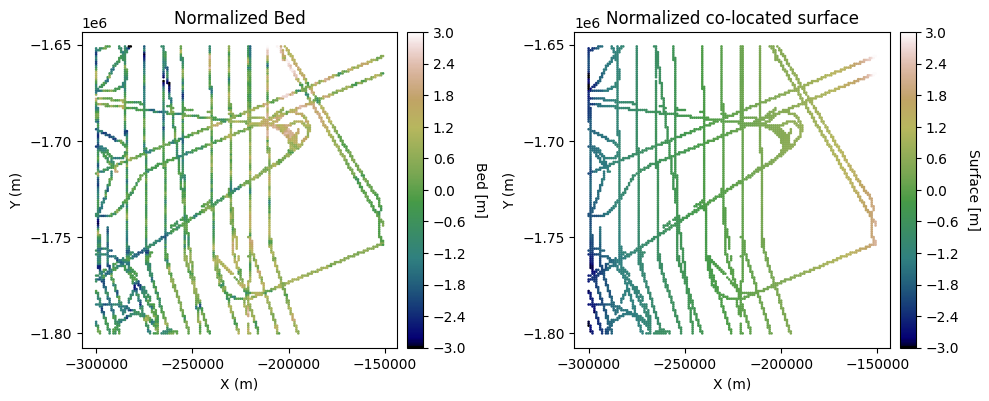

In [7]:
# plot normalized co-located data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))    
im = ax1.scatter(df_grid['X'], df_grid['Y'], c=df_grid['Nbed'], vmin=-3, vmax=3, cmap='gist_earth', 
                 s=3, marker=".")
ax1.set_title('Normalized Bed')
ax1.set_xlabel('X (m)'); ax1.set_ylabel('Y (m)')
ax1.locator_params(nbins=5)
cbar = make_colorbar(fig, im, -3, 3, clabel='Bed [m]', ax=ax1)
ax1.axis('scaled')

im = ax2.scatter(df_grid['X'], df_grid['Y'], c=df_colocated['colocated'], vmin=-3, vmax=3, cmap='gist_earth', 
                 s=3, marker=".")
ax2.set_title('Normalized co-located surface')
ax2.set_xlabel('X (m)'); ax2.set_ylabel('Y (m)')
ax2.locator_params(nbins=5)
cbar = make_colorbar(fig, im, -3, 3, clabel='Surface [m]', ax=ax2)
ax2.axis('scaled')

plt.tight_layout()
plt.show()

In [8]:
# compute correlation coefficient
rho12 = np.corrcoef(df_grid['Nbed'],df_colocated['colocated'])
corrcoef = rho12[0,1]
print('Correlation coefficient between bed and surface: ' + str(corrcoef))

Correlation coefficient between bed and surface: 0.5716847267189374


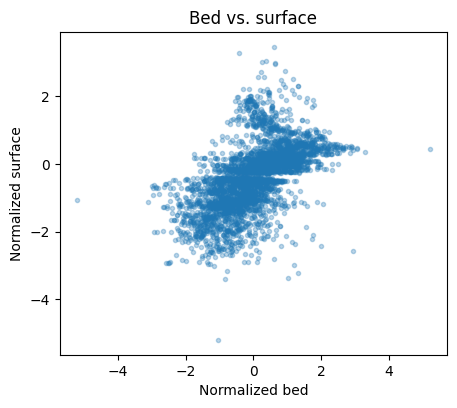

In [9]:
# scatter plot
plt.figure(figsize=(5,5))
im = plt.scatter(df_grid['Nbed'], df_colocated['colocated'], alpha=0.3, marker='.')
plt.title('Bed vs. surface')
plt.xlabel('Normalized bed')
plt.ylabel('Normalized surface')
plt.axis('scaled')
plt.show()

Note that the scatter plot must be homoscedastic. In other words, if it looks like the strength of the correlation changes throughout the plot, then the secondary data shouldn't be used. $Z_1$ and $Z_2$ must be linearly related for cokriging and cosimulation to work.

## Initialize grid

First we need to define a grid to interpolate. This stores an array of coordinates for the simulation.

In [10]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Cokriging

To perform cokriging, just enter the primary variogram and correlation coefficient parameters into the cokrige_mm1 function:

In [11]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1] 
vario = [azimuth, nugget, major_range, minor_range, sill]

k = 100         # number of neighboring data points used to estimate a given point 
rad = 50000     # 50 km search radius

est_cokrige, var_cokrige = gs.Interpolation.cokrige_mm1(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 
                                     df_surface_grid, 'X', 'Y', 'Nsurf', k, vario, rad, corrcoef) 

100%|████████████████████████████████████████████████████████████████████████████| 22500/22500 [04:01<00:00, 93.32it/s]


In [12]:
# reverse normal score transformation
var_cokrige[var_cokrige < 0] = 0; # make sure variances are non-negative
std_cokrige = np.sqrt(var_cokrige) # convert to standard deviation (this should be done before back transforming!!!)

# reshape
est = est_cokrige.reshape(-1,1)
std = std_cokrige.reshape(-1,1)

# back transformation
cokrige_pred_trans = nst_trans.inverse_transform(est)
cokrige_std_trans = nst_trans.inverse_transform(std)
cokrige_std_trans = cokrige_std_trans - np.min(cokrige_std_trans)

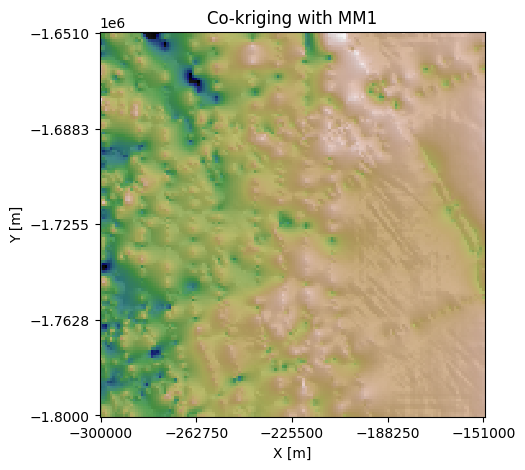

In [13]:
mplot1(Pred_grid_xy, cokrige_pred_trans, rows, cols, title='Co-kriging with MM1', hillshade=True)

Compared to the simple and ordinary kriging estimates, the elevation on the right side of the map is visibly higher. This is because the surface elevation data slopes upward to the right, which pulls the interpolated topography upwards. 

Because only one secondary data point is used to estimate each grid cell, the collocated cokriging variance ends up being almost identical to the kriging variance. This can sometimes lead to an overestimation of the variance. 

## Sequential Gaussian co-simulation (Co-SGS)

Now we will perform simulation using cokriging.

In [14]:
cosim = gs.Interpolation.cosim_mm1(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 
                                     df_surface_grid, 'X', 'Y', 'Nsurf', k, vario, rad, corrcoef)

100%|████████████████████████████████████████████████████████████████████████████| 22500/22500 [04:47<00:00, 78.26it/s]


In [15]:
# reverse normal score transformation
sgs_cosim = cosim.reshape(-1,1)
cosim_trans = nst_trans.inverse_transform(sgs_cosim)

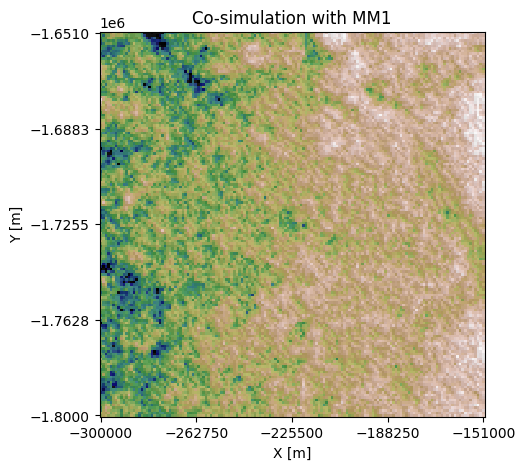

In [16]:
mplot1(Pred_grid_xy, cosim_trans, rows, cols, title='Co-simulation with MM1', hillshade=True)

Looks good! Compared to the previous simulation examples, the topography on the right is higher elevation. 

## Post-simulation analysis

Let's examine some of the statistical properties of the co-simulation:

In [17]:
# variogram comparison
# downsample random indices to speed this up
rand_indices = random.sample(range(np.shape(Pred_grid_xy)[0]),5000)

# get normalized cosimulation data
coords_s = Pred_grid_xy[rand_indices]
values_s = cosim[rand_indices]

VS = skg.Variogram(coords_s, values_s, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

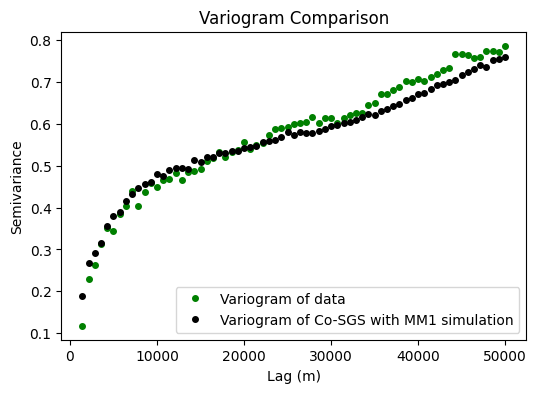

In [18]:
# plot variogram

# extract variogram values

# experimental variogram (from beginning of script)
xe = V1.bins
ye = V1.experimental

# simple kriging variogram
xs = VS.bins
ys = VS.experimental

plt.figure(figsize=(6,4))
plt.plot(xe, ye, 'og', markersize=4, label='Variogram of data')
plt.plot(xs, ys, 'ok', markersize=4, label='Variogram of Co-SGS with MM1 simulation')
plt.title('Variogram Comparison')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')  
plt.legend(loc='lower right')
plt.show()

In [19]:
# find correlation coefficient between total surface dataset and simulation 

rho12 = np.corrcoef(cosim,df_surface_grid['Nsurf']) # compute correlation coefficient
corrcoef = rho12[0,1]
print('Correlation coefficient between simulated bed and surface: ' + str(corrcoef))

Correlation coefficient between simulated bed and surface: 0.7275644209402902


Based on our post-simulation analysis, it appears that the MM1 simulation reproduces the variogram statistics of observations, but exaggerates the correlation betweehn the bed and the surface. This is a known issue with MM1 and is something to watch out for. This over-correlation can sometimes create simulation artifacts as well. Generally speaking, MM1 works best if the secondary data has a higher variance (i.e. is rougher) than the primary data.